In [61]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

def load_dataset(dataset, height, width, channels):
  (X_train, Y_train), (X_test, Y_test) = dataset.load_data()
  X_train = X_train.reshape((X_train.shape[0], height, width, channels))
  X_test = X_test.reshape((X_test.shape[0], height, width, channels))
  Y_train = to_categorical(Y_train)
  Y_test = to_categorical(Y_test)
  return X_train, Y_train, X_test, Y_test

In [62]:
def prepare_dataset(X_train, X_test):
  X_train_norm = X_train.astype('float32')
  X_test_norm = X_test.astype('float32')
  # normalize to range 0-1
  X_train_norm = X_train_norm / 255.0
  X_test_norm = X_test_norm / 255.0
  # return normalized images
  return X_train_norm, X_test_norm

In [63]:
def sampling(args):
    z_mean, z_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_var) * epsilon

In [64]:
import keras
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded, z_mean, z_var):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_var - K.square(z_mean) - K.exp(z_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mean = inputs[2]
        z_var = inputs[3]
        loss = self.vae_loss(x, z_decoded, z_mean, z_var)
        self.add_loss(loss, inputs=inputs)
        return x

In [65]:
import keras
import numpy as np
from keras import layers
from keras import backend as K
from keras.models import Model

def create_models(image_shape, latent_dim): 
  # defining input image
  input_image = keras.Input(shape=image_shape)

  conv_layer_1 = layers.Conv2D(32, 3, padding='same', activation='relu')(input_image)
  conv_layer_2 = layers.Conv2D(64, 3, padding='same', activation='relu', strides = (2,2))(conv_layer_1)
  conv_layer_3 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv_layer_2)
  conv_layer_4 = layers.Conv2D(64, 3, padding='same', activation='relu')(conv_layer_3)

  shape_before_flattening = K.int_shape(conv_layer_2)
  flattened_layer = layers.Flatten()(conv_layer_2)
  dense_layer = layers.Dense(32, activation='relu')(flattened_layer)

  
  # defining point distribution through mean and variance
  z_mean = layers.Dense(latent_dim)(dense_layer)
  z_var = layers.Dense(latent_dim)(dense_layer) 
  # non trainable custom layer
  z = layers.Lambda(sampling)([z_mean, z_var])

  # decoder implementation. You reshape the vector z to the dimensions of an image
  # and then use a few convolution layers to obtain a final
  # image output that has the same dimensions as the original input_img.

  decoder_input_shape = K.int_shape(z)[1:]
  # equals to latent dimension
  decoder_input = layers.Input(decoder_input_shape)
  # number of neurons equals to the product of the elements of the tensor shape of the final conv layer  
  number_of_neurons_dense = np.prod(shape_before_flattening[1:])
  x = layers.Dense(number_of_neurons_dense, activation='relu')(decoder_input)
  x = layers.Reshape(shape_before_flattening[1:])(x)
  x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
  x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)
  decoder = Model(decoder_input, x)
  z_decoded = decoder(z)

  y = CustomVariationalLayer()([input_image, z_decoded, z_mean, z_var])

  # Because the loss is taken care of in the custom layer, you don’t specify an external loss
  # at compile time ( loss=None ), which in turn means you won’t pass target data during training
  # (as you can see, you only pass x_train to the model in fit ).

  vae = Model(input_image, y)

  return vae, decoder


In [66]:
def train_model(X_train, X_test, epochs, batches, model):
    history = model.fit(x=X_train, y=None, shuffle=True, epochs=5, batch_size=batch_size, validation_data=(X_test, None))
    history_dict = history.history;
    return history_dict

In [67]:
height = 28
width = 28
channels = 1
batch_size = 16
latent_dim = 2
epochs = 5
image_shape = (width, height, channels)

X_train, Y_train, X_test, Y_test = load_dataset(fashion_mnist, height, width, channels)
X_train, X_test = prepare_dataset(X_train, X_test)

vae, decoder = create_models(image_shape, latent_dim)
vae.compile(optimizer='adam', loss=None, experimental_run_tf_function=False)
print("----- SUMMARY OF VAE ------")
vae.summary()
print("----- SUMMARY OF DECODER -----")
decoder.summary()
history_dict = train_model(X_train, X_test, epochs=epochs, batches=batch_size, model=vae)


----- SUMMARY OF VAE ------
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_49 (Conv2D)             (None, 28, 28, 32)   320         ['input_21[0][0]']               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 14, 14, 64)   18496       ['conv2d_49[0][0]']              
                                                                                                  
 flatten_10 (Flatten)           (None, 12544)        0           ['conv2d_50[0][0]']              
                                                               

1/1 [==============================] - 0s 12ms/step


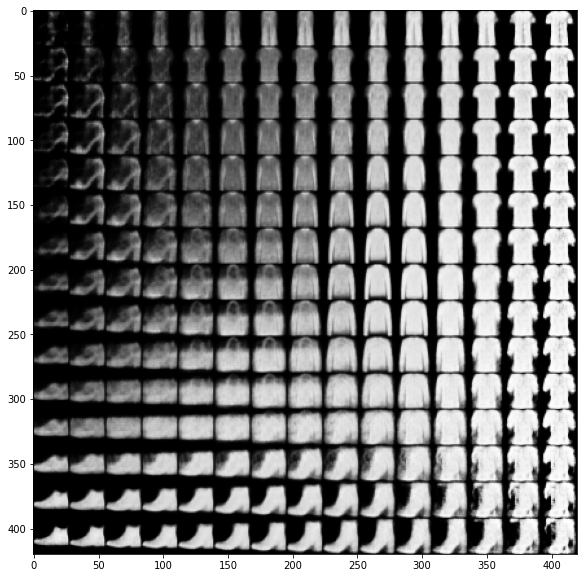

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# sampling new data from latent space 

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit

plt.figure(1,figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()